# Основная работа с данными

In [89]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/lera/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist', 'size', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [90]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
import scipy.interpolate as inter
from matplotlib import cm
import matplotlib.patches as patches
import math

In [91]:
import functions

In [92]:
Distance = 10.57 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [93]:

def cut_fits(first_fits=None, second_fits=None, size=None):
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2)
    cposition1 = SkyCoord('170.06318266 12.99640067'.format(first_WCS.wcs.crval[0], first_WCS.wcs.crval[1]), frame='icrs', unit='deg')
    
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    cposition2 = SkyCoord('{} {}'.format(second_WCS.wcs.crval[0], second_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition2, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition2, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

In [94]:
def create_new_grid(first_fits=None, second_fits=None, size=None):
    first_data, second_data = cut_fits(first_fits=first_fits, second_fits=second_fits, size=size)
    shape = first_data.shape
    first_data_wcs = first_data.wcs
    X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
    sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data_wcs).reshape((shape[0], shape[1]))
    
    grid_pixs = []
    new_second_data = []
    for scoord in sgrid.ravel():
        spix = skycoord_to_pixel(scoord, second_data.wcs)
        grid_pixs.append(spix)
        new_second_data.append(second_data.data[int(spix[1])][int(spix[0])])
    
    return grid_pixs, new_second_data  

### Разберёмся с данными из VENGA

## $\sigma_s$



данные взяты из этого [каталога](https://users.obs.carnegiescience.edu/~gblancm/venga/vengacubes/NGC3627/) - 

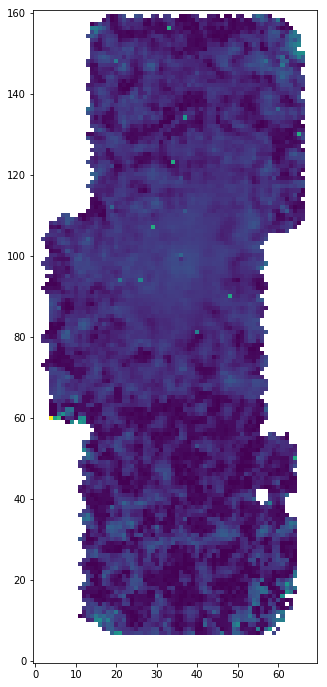

In [95]:
functions.fits_file('./data/NGC3627_map_sigstar.fits', 7, 12)

In [96]:
def cut_fits_for_sigmaS(first_fits=None, second_fits=None, size=None):
    first_data = fits.getdata(first_fits)
    first_data = np.squeeze(first_data)
    first_WCS = WCS(first_fits, naxis = 2)
    cposition1 = SkyCoord('170.06318266 12.99640067'.format(first_WCS.wcs.crval[0], first_WCS.wcs.crval[1]), frame='icrs', unit='deg')
    
    second_data = fits.getdata(second_fits)
    second_data = np.squeeze(second_data)
    second_WCS = WCS(second_fits, naxis = 2)
    cposition2 = SkyCoord('{} {}'.format(second_WCS.wcs.crval[0], second_WCS.wcs.crval[1]), frame='fk5', unit='deg', equinox='J2000.0')
    
    size = u.Quantity(size, u.arcsec)
    
    first_data = Cutout2D(first_data, cposition1, size, wcs=first_WCS, mode='partial', fill_value=0.)
    second_data = Cutout2D(second_data, cposition1, size, wcs=second_WCS, mode='partial', fill_value=0.)
    
    return first_data, second_data  

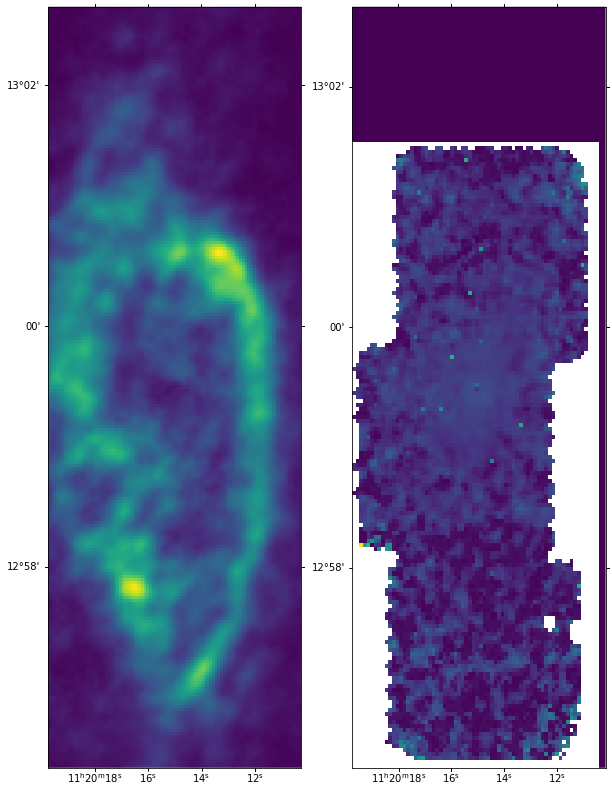

(253, 93)
(190, 70)


In [97]:
size = [380,140]
sigma_s, second = cut_fits(first_fits = './data/NGC3627_map_sigstar.fits', second_fits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 

fig = plt.figure(figsize=[10, 14])
ax = fig.add_subplot(121, projection=second.wcs)

ax.imshow(second.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=sigma_s.wcs)
ax2.imshow(sigma_s.data, origin='lower', aspect="auto")

plt.show()

print(second.shape)
print(sigma_s.shape)



In [98]:
sigma_s = np.array(sigma_s.data).reshape(190,70)

## $H_\alpha$ (VENGA)

данные взяты из этого [каталога](https://users.obs.carnegiescience.edu/~gblancm/venga/vengacubes/NGC3627/) - 

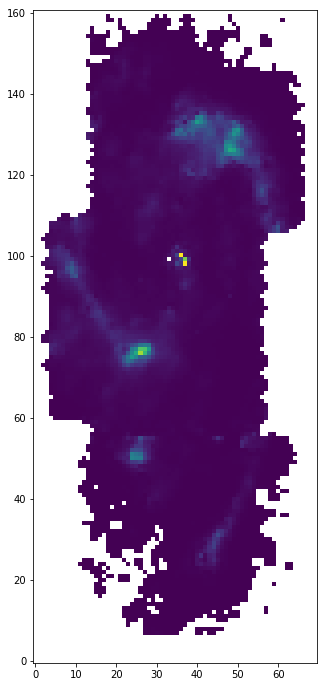

In [99]:
functions.fits_file('./data/NGC3627_map_ha_corr.fits', 7, 12)

## $\Sigma_{HI}$ (THINGS)

$$\Sigma_{HI}(M_{\odot} pc^{-2}) = 0.020\cos(i) I_{21 cm}(K km s^{-1})$$ Leroy08(A1)

Walter пишет:
> Throughout the paper we give the noise in mJy beam−1. The noise in Kelvin can be calculated using the following equation:$$T[K] = 6.07\times 10^5\times S[Jy beam^{-1}]/(B_{maj}\times B_{min}),$$ где $B_{maj},B_{min}$ - размеры бима в секундах.

Размеры бима из статьи: 10.60 8.85

In [100]:
scale = (Distance*1000*2*np.pi)/(360*60*60.) # kpc/acrsec
#Получается следующая формула:
S = lambda x: (6.07 * 2 * 1000 * cosi * x) / (10.6 * 8.85 * scale**2 * 1000**2)/1.36

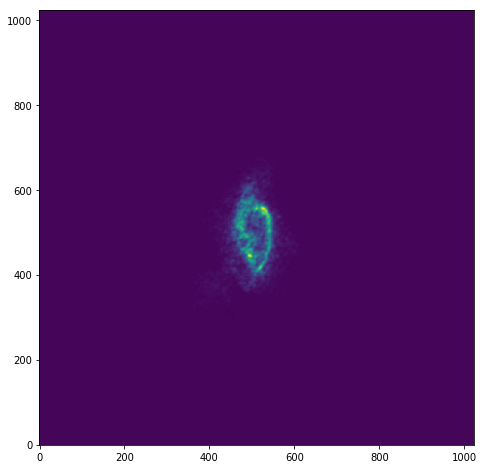

In [101]:
functions.fits_file('./data/NGC_3627_NA_MOM0_THINGS.FITS', 8, 8)

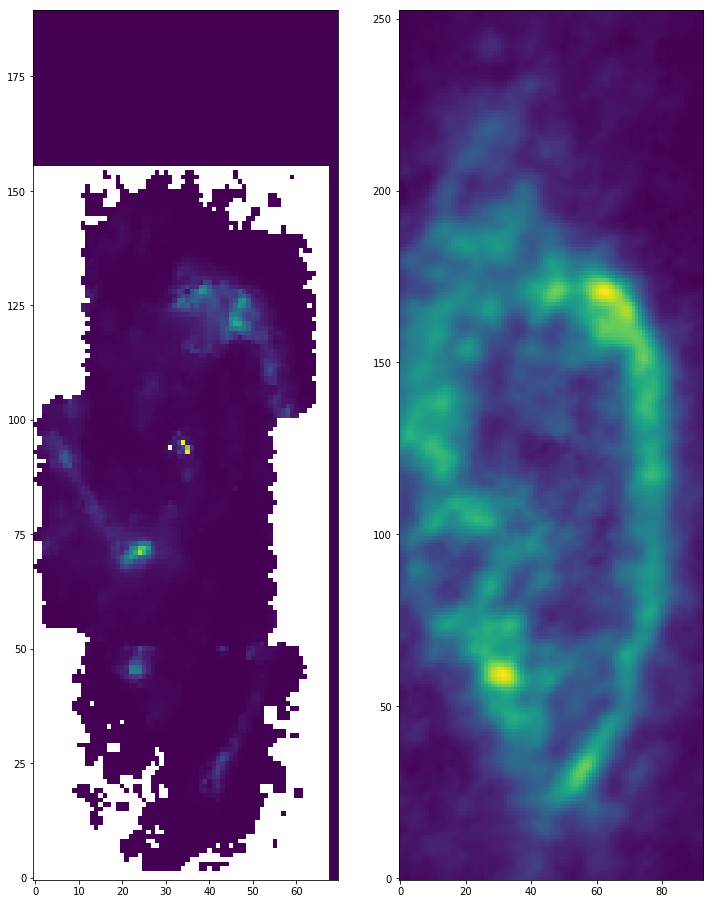

(190, 70)
(253, 93)


In [102]:
size = [380,140] 
first_data, second_data = cut_fits(first_fits='./data/NGC3627_map_ha_corr.fits', second_fits='./data/NGC_3627_NA_MOM0_THINGS.FITS', size=size) 

fig, [ax, ax2] = plt.subplots(figsize=[12, 16], ncols=2)
ax.imshow(first_data.data, origin='lower', aspect="auto")
ax2.imshow(second_data.data, origin='lower', aspect="auto")
plt.show()

print(first_data.shape)
print(second_data.shape)  

In [103]:
size = [380,140]
grid_pix, I_fl = create_new_grid(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM0_THINGS.FITS', size = size) 


In [104]:
I_fl = np.array(I_fl).reshape(190,70)

In [105]:
Sigma_HI = S(I_fl)

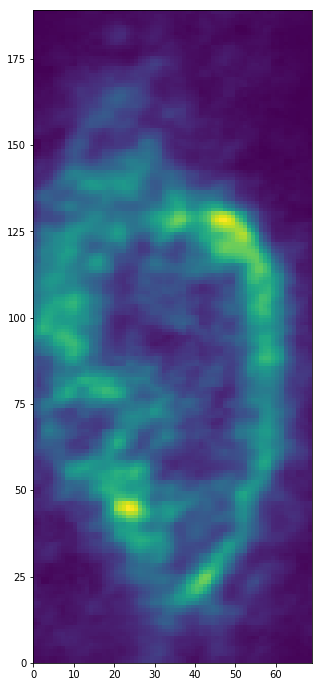

In [106]:
fig = plt.figure(figsize = [5,12])
Z = Sigma_HI
X, Y = np.meshgrid(np.arange(0,70,1), np.arange(0,190,1))
plt.pcolormesh(X, Y, Z)

In [107]:
np.save('Sigma_HI.npy',Sigma_HI)

## $\sigma_{HI}$ (THINGS)

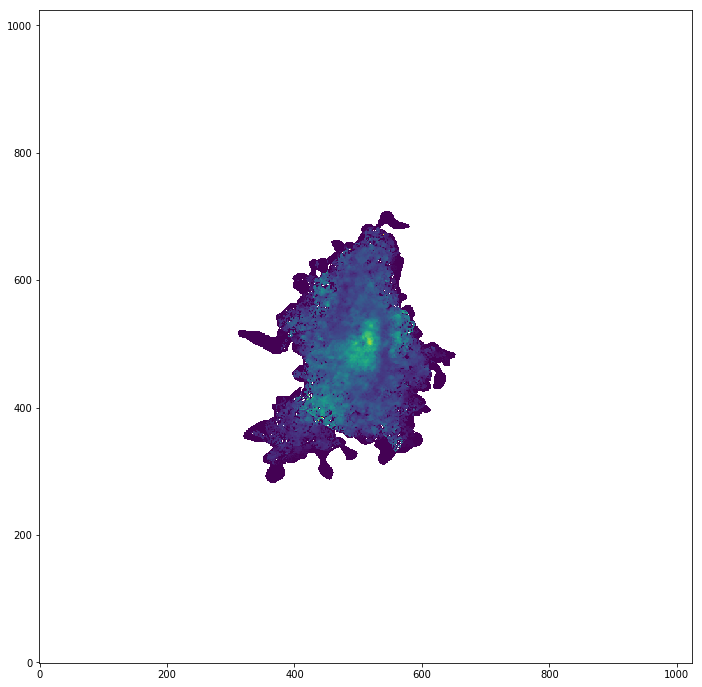

In [108]:
functions.fits_file('./data/NGC_3627_NA_MOM2_THINGS.FITS', 12, 12)

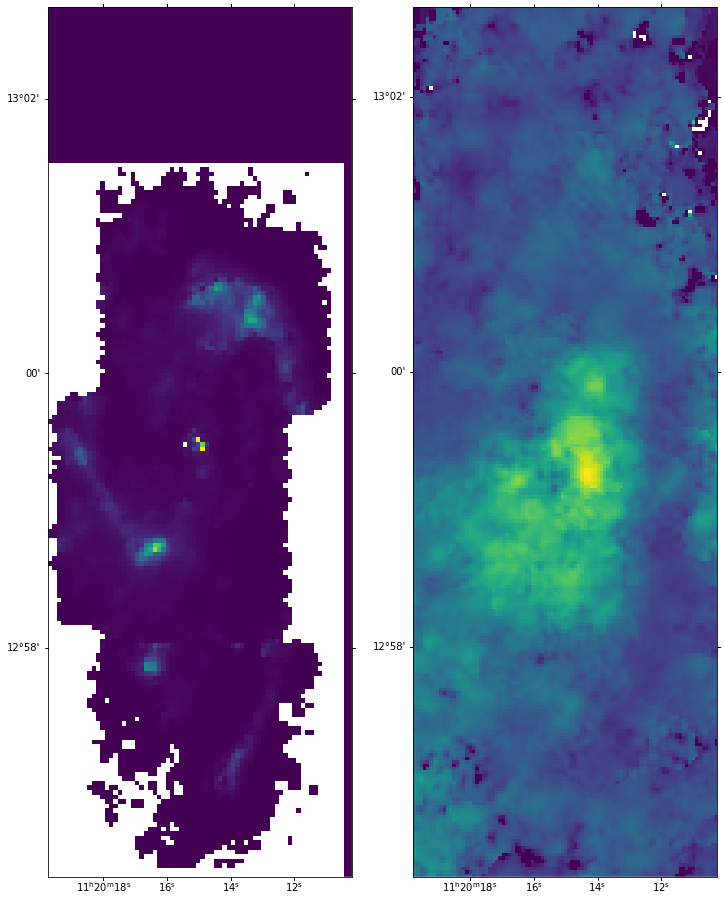

(190, 70)
(253, 93)


In [109]:
size = [380,140]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM2_THINGS.FITS', size = size)
fig = plt.figure(figsize=[12, 16])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")

plt.show()

print(first_data.shape)
print(second_data.shape)

In [110]:
size = [380,140]
grid_pix, sigma_HI = create_new_grid(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM2_THINGS.FITS', size = size) 

In [111]:
sigma_HI = np.array(sigma_HI).reshape(190,70)

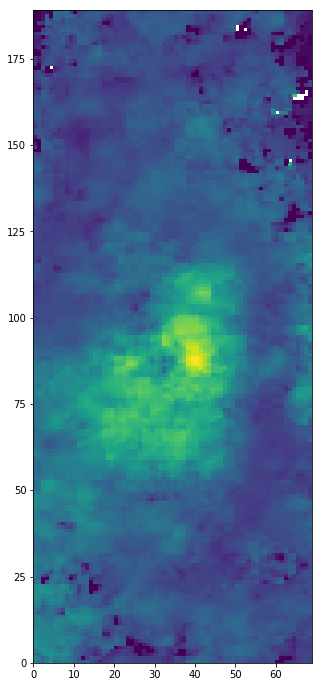

In [112]:
fig = plt.figure(figsize = [5,12])
Z = sigma_HI
X, Y = np.meshgrid(np.arange(0,70,1), np.arange(0,190,1))
plt.pcolormesh(X, Y, Z)

## $\Sigma_{H2}$ & $I_{CO}$ (HERACLES)

Эти данные находятся по следующей схеме:
- Нужно перейти по следующей [ссылке](https://ned.ipac.caltech.edu/byname?objname=n3627&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1)
- Зайти в images
- Набрать в поиске название телескопа IRAM
- Далее там появятся все данные по CO(2-1) из каталога HERACLES

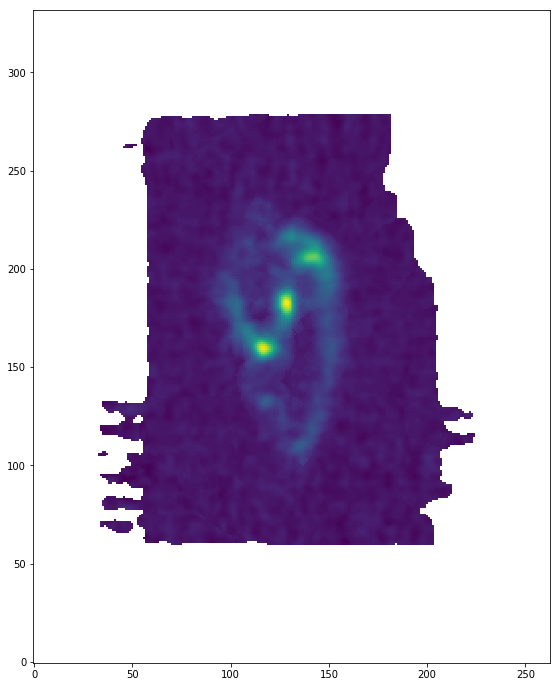

In [113]:
functions.fits_file('./data/ngc3627_mom0_I_CO_J1-2_lwb2009.fits', 10, 12)

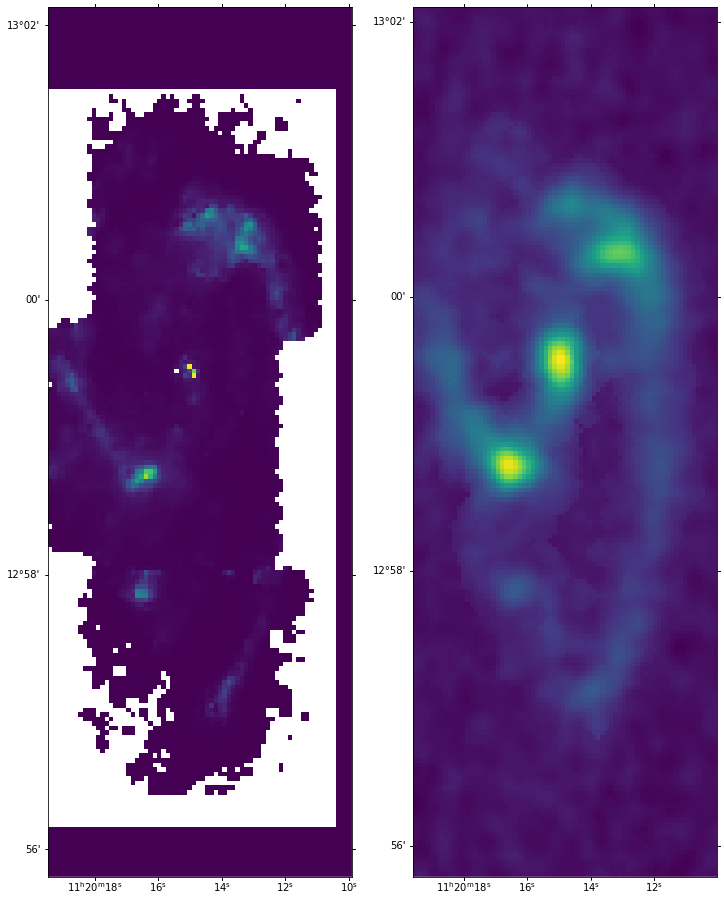

(190, 70)
(190, 70)


In [114]:
size = [380,140]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/ngc3627_mom0_I_CO_J1-2_lwb2009.fits', size = size)
fig = plt.figure(figsize=[12, 16])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")



plt.show()

print(first_data.shape)
print(second_data.shape)

In [115]:
I_CO = np.array(second_data.data).reshape(190,70)

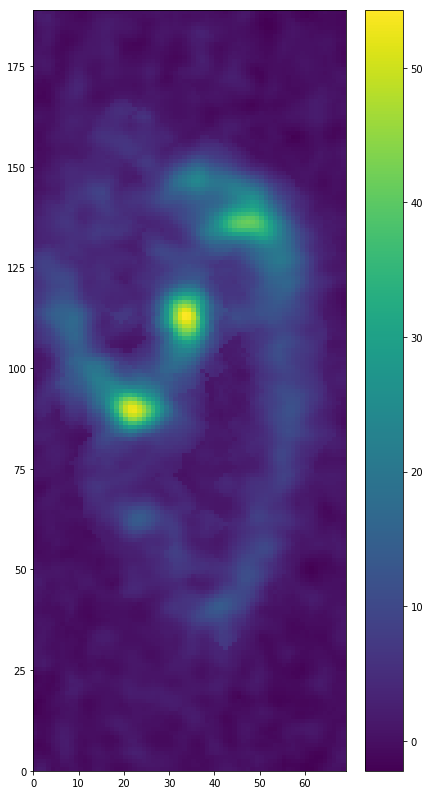

In [116]:
fig = plt.figure(figsize = [7,14])
Z = I_CO
X, Y = np.meshgrid(np.arange(0,70,1), np.arange(0,190,1))
picture=plt.pcolormesh(X,Y,Z)
plt.colorbar()
plt.show()

Получим $\Sigma_{H2}$ из $I_{CO}$: 
$$\Sigma_{H_2} = 5.5\cos i \times I_{CO(2-1)}$$

In [117]:
Sigma_H2 = 5.5 * cosi * I_CO

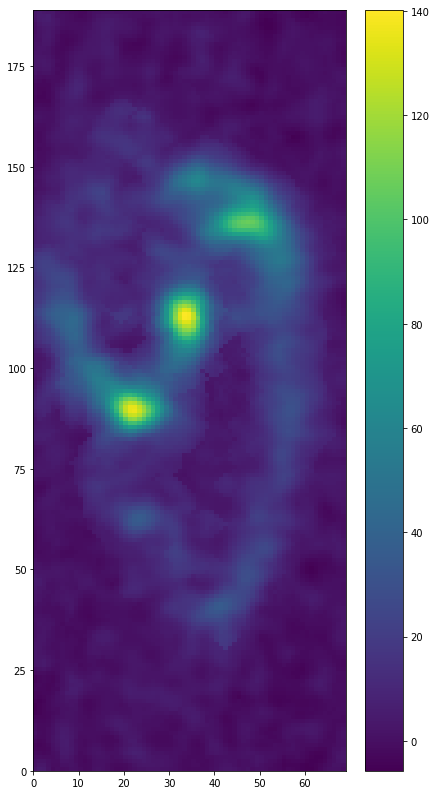

In [118]:
fig = plt.figure(figsize = [7,14])
Z = Sigma_H2
X, Y = np.meshgrid(np.arange(0,70,1), np.arange(0,190,1))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

## $\Sigma_s$

данные из [этого каталога](https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=S4G&hdr_location=%2Fwork%2FTMP_wlu2WK_23092%2FAtlas%2F11h_20m_15.02s_%2B12d_59m_29.50s_Equ_J2000_22792.v0001&collection_desc=S4G&locstr=11h+20m+15.02s+%2B12d+59m+29.50s+Equ+J2000&regSize=0.25&radius=7.5&radunits=arcmin&searchregion=on)

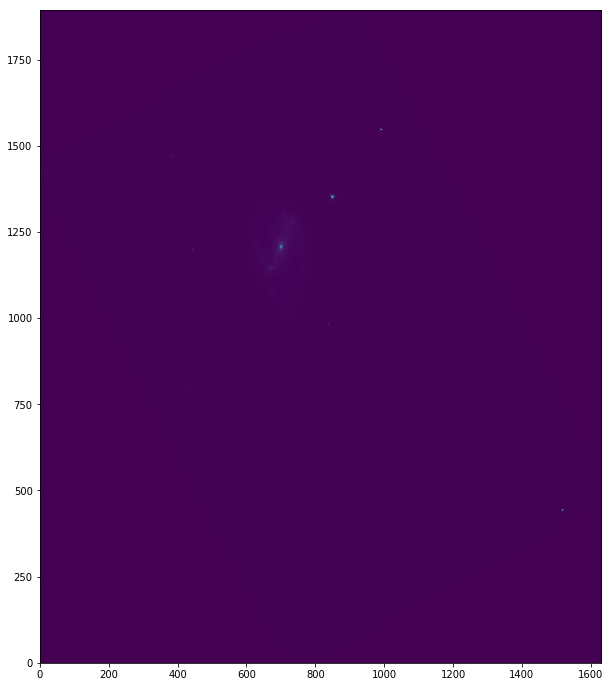

In [119]:
functions.fits_file('./data/NGC3627.phot.1_nonan.fits', 12, 12)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


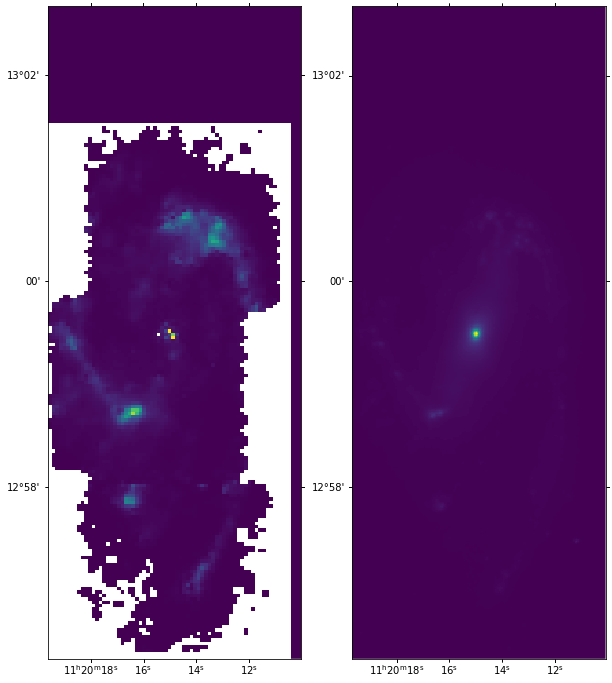

(190, 70)
(507, 187)


In [120]:
size = [380,140]
first_data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size) 
fig = plt.figure(figsize=[10, 12])
ax = fig.add_subplot(121, projection=first_data.wcs)

ax.imshow(first_data.data, origin='lower', aspect="auto")

ax2 = fig.add_subplot(122, projection=second_data.wcs)
ax2.imshow(second_data.data, origin='lower', aspect="auto")

plt.show()

print(first_data.shape)
print(second_data.shape)  

In [121]:
def create_new_grid_for_SigmaS(first_fits=None, second_fits=None, size=None):
    first_data, second_data = cut_fits(first_fits=first_fits, second_fits=second_fits, size=size)
    shape = first_data.shape
    first_data_wcs = first_data.wcs
    X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
    sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data_wcs).reshape((shape[0], shape[1]))
    
    grid_pixs = []
    new_second_data = []
    for scoord in sgrid.ravel():
        spix = skycoord_to_pixel(scoord, second_data.wcs)
       
        if (spix[0]<186):
            grid_pixs.append(spix)
            new_second_data.append(second_data.data[int(spix[1])][int(spix[0])])
    
    return grid_pixs, new_second_data  

In [122]:
size = [380,140]
grid_pix, Sigma_s = create_new_grid_for_SigmaS(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size) 

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [123]:
len(grid_pix)

13110

In [124]:
Sigma_s = np.array(Sigma_s).reshape(190,69)
H_alpha = np.array(first_data.data).reshape(190,70)

$$\Sigma_{s} = 280 \cos(i) I_{3.6}$$

In [125]:
Sigma_s = Sigma_s * 280 * cosi

Соберём все полученные данные в общую картину

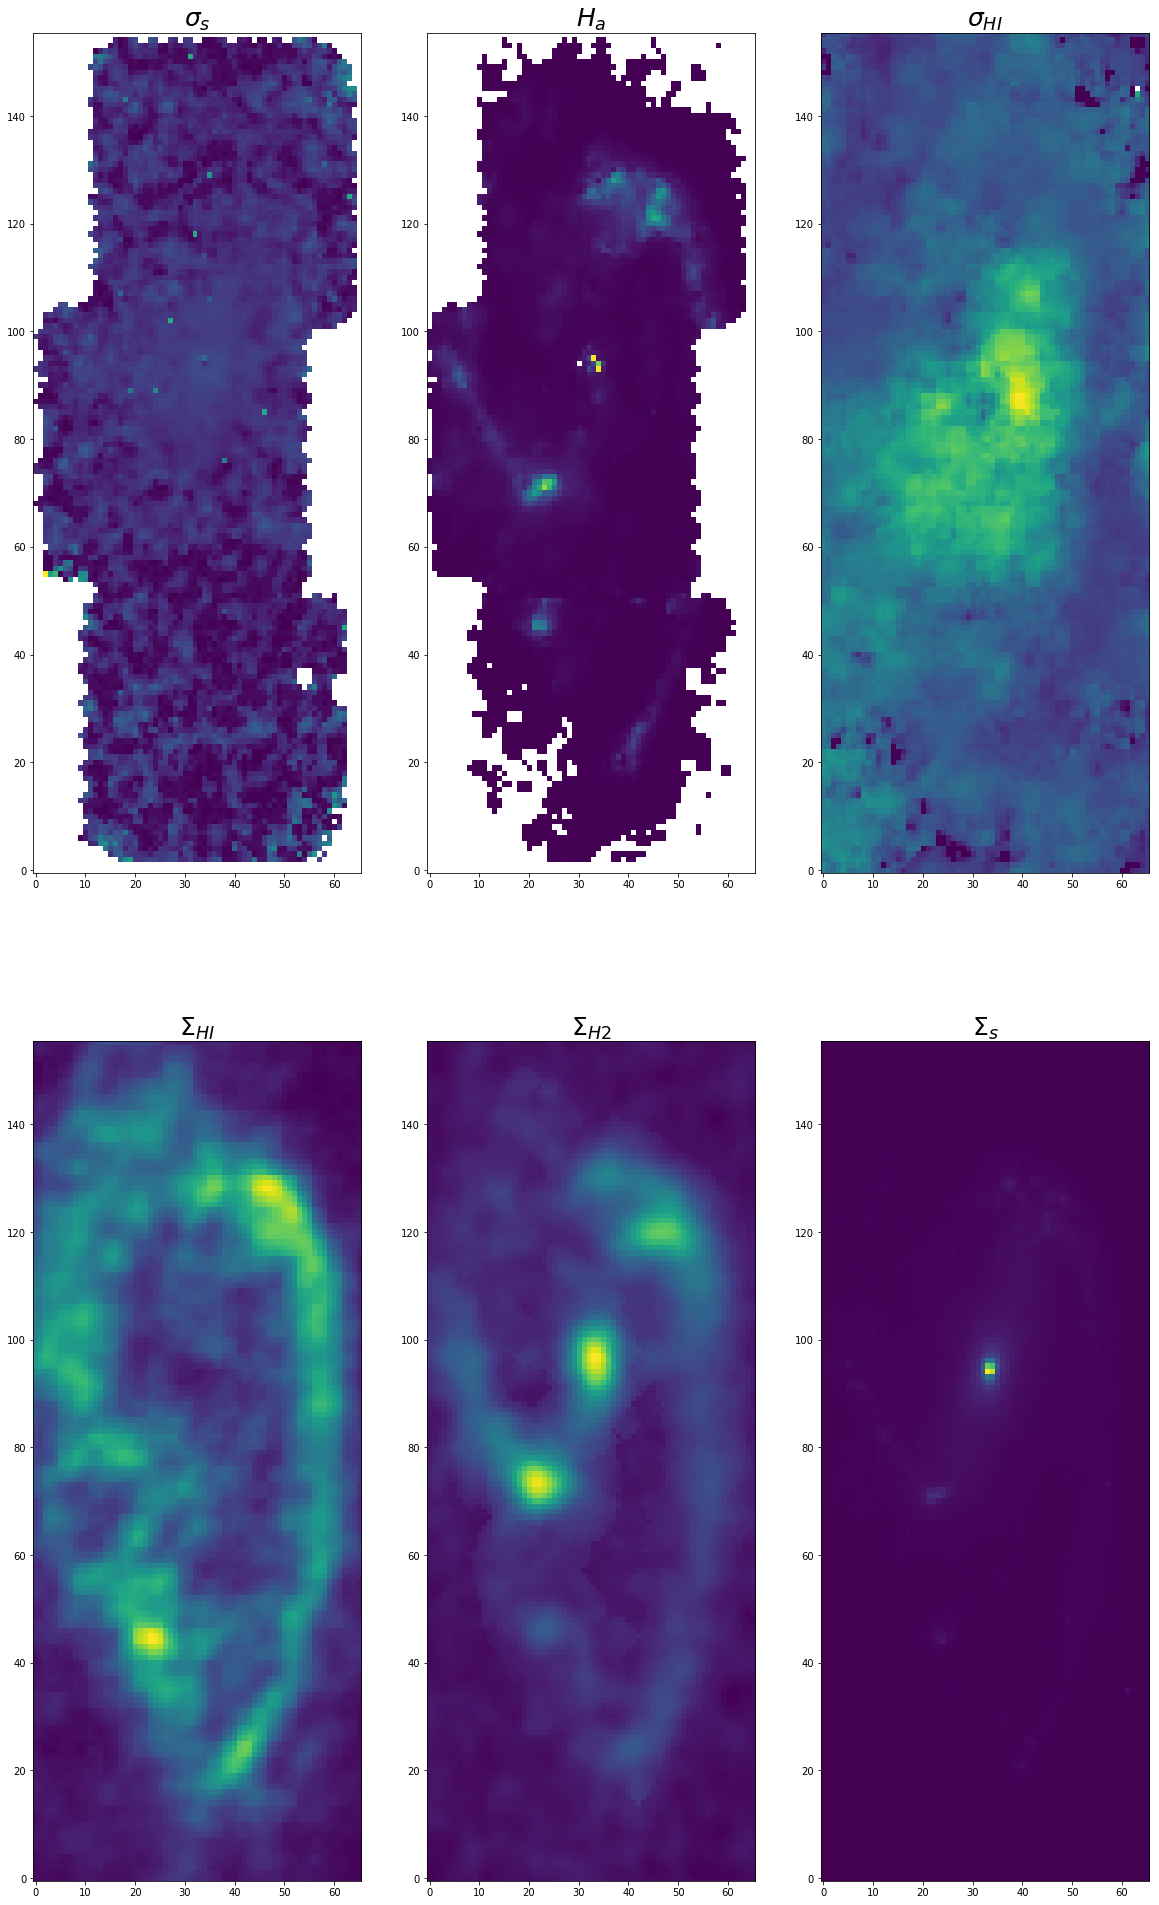

(156, 66) (190, 70)
(156, 66) (190, 70)
(156, 66) (190, 70)
(156, 66) (190, 70)
(156, 66) (190, 70)
(156, 66) (190, 69)


In [126]:
fig = plt.figure(figsize=[20,34])
ax1 = fig.add_subplot(231)
sigma_s_cut = sigma_s[0:-34,0:-4]
ax1.imshow(sigma_s_cut.data, origin='lower', aspect="auto")
plt.title('$\sigma_s$', fontsize=25)

ax2 = fig.add_subplot(232)
H_alpha_cut = H_alpha[0:-34,0:-4]
ax2.imshow(H_alpha_cut.data, origin='lower', aspect="auto")
plt.title('$H_a$', fontsize=25)

ax3 = fig.add_subplot(235)
Sigma_H2_cut = Sigma_H2[16:-18,0:-4]
ax3.imshow(Sigma_H2_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{H2}$', fontsize=25)

ax4 = fig.add_subplot(233)
sigma_HI_cut = sigma_HI[0:-34,0:-4]
ax4.imshow(sigma_HI_cut.data,origin='lower', aspect="auto")
plt.title('$\sigma_{HI}$', fontsize=25)

ax5 = fig.add_subplot(234)#
Sigma_HI_cut = Sigma_HI[0:-34,0:-4] 
ax5.imshow(Sigma_HI_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{HI}$', fontsize=25)

ax6 = fig.add_subplot(236)
Sigma_s_cut = Sigma_s[0:-34,0:-3]
ax6.imshow(Sigma_s_cut.data, origin='lower', aspect="auto")
plt.title('$\Sigma_{s}$', fontsize=25)

plt.show()
print(sigma_s_cut.shape, sigma_s.shape)
print(H_alpha_cut.shape, H_alpha.shape)
print(Sigma_H2_cut.shape, Sigma_H2.shape)
print(sigma_HI_cut.shape, sigma_HI.shape)
print(Sigma_HI_cut.shape, Sigma_HI.shape)
print(Sigma_s_cut.shape, Sigma_s.shape)

In [127]:
Sigma_s = Sigma_s[0:-34,0:-3]
np.save('Sigma_s.npy', Sigma_s)

In [128]:
sigma_s = sigma_s[0:-34,0:-4]
H_alpha = H_alpha[0:-34,0:-4]
Sigma_H2 = Sigma_H2[16:-18,0:-4]
sigma_HI = sigma_HI[0:-34,0:-4]
Sigma_HI = Sigma_HI[0:-34,0:-4] 


In [129]:
np.save('sigma_s.npy', sigma_s)
np.save('H_alpha.npy', H_alpha)
np.save('Sigma_H2.npy', Sigma_H2)
np.save('sigma_HI.npy', sigma_HI)
np.save('Sigma_HI.npy', Sigma_HI)


## Velocity curve

In [130]:
from IPython.display import Image

Velocity curve из этой статьи https://arxiv.org/pdf/1808.07483.pdf


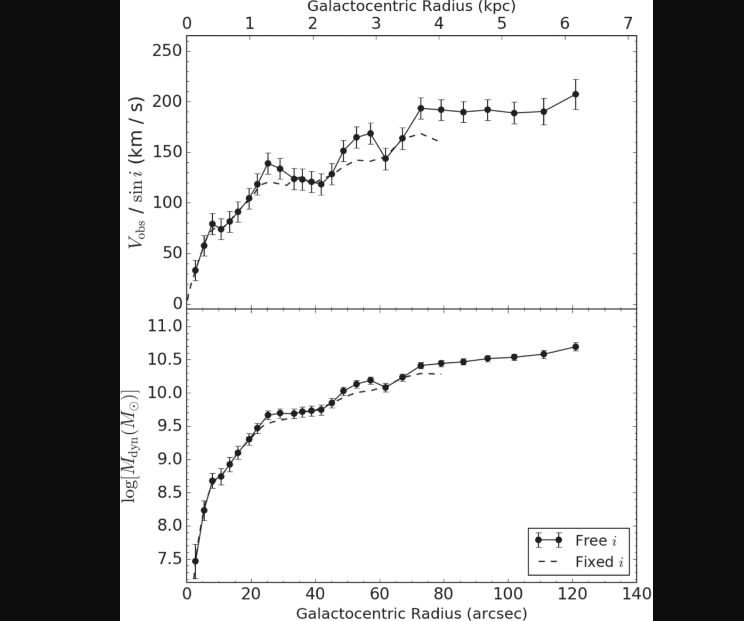

In [131]:
Image(filename='./images/velocity_curve.png')

 В [статье](https://arxiv.org/pdf/1808.07483.pdf) написано
 > the freely-varying inclination iteration more closely recovers the expected PA = 178◦ of NGC 3627
 
 поэтому могу считать,что эта кривая соответствуют кривой вращения с P.A.=178 

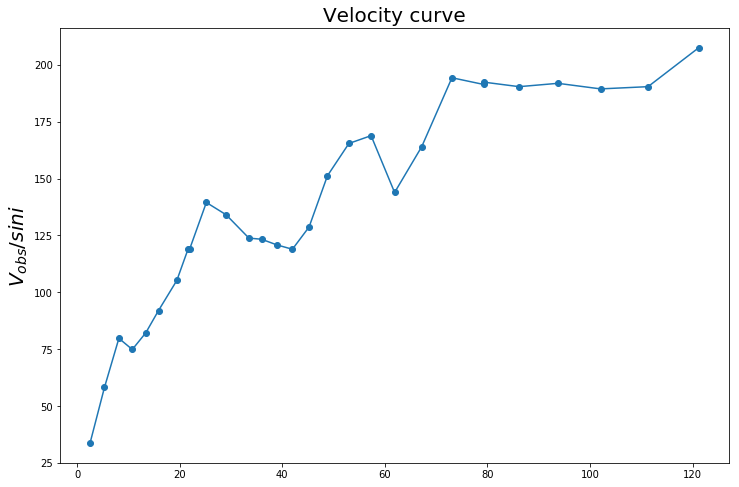

In [132]:
file_in=open('velocity_curve.dat','r')
data = file_in.readlines()
x = []
y = []
for i in data:
    x.append(float(i.split()[0]))
    y.append(float(i.split()[1])) 
fig = plt.figure(figsize = [12,8])     
plt.plot(x ,y,'o-')
plt.title('Velocity curve',fontsize = 20)
plt.ylabel('$V_{obs} / sin i$',fontsize = 20)
plt.show()

Переведём arcsec в kpc



In [133]:
rad = [r * np.pi / (180 *3600) * Distance * 10**3 for r in x] 

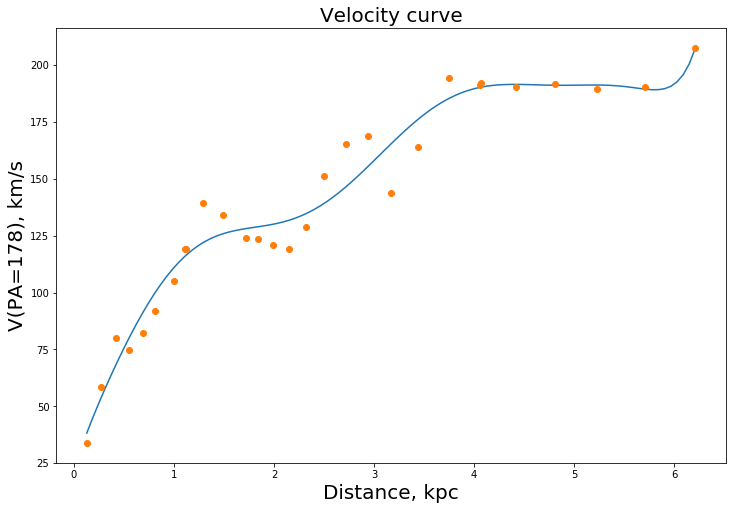

In [134]:
#Проинтерполируем 
vel = y

points = np.linspace(min(rad), max(rad), 100)
velocity_approx = poly1d(polyfit(rad, vel, deg=9))
fig = plt.figure(figsize = [12,8])     
line = plt.plot(points, velocity_approx(points))
line1 = plt.plot(rad, vel, 'o')
plt.title('Velocity curve',fontsize = 20)
plt.ylabel('V(PA=178), km/s', fontsize = 20)
plt.xlabel('Distance, kpc', fontsize = 20)
plt.show()


In [135]:
r_Law = np.save('r_Law.npy',points)
vel_Law = np.save('vel_Law',velocity_approx(points))

In [136]:
#file_in=open('result.dat','r') #Просто интерполяция сплайном из вычей
#data = file_in.readlines()
#x = []
#y = []
#for i in data:
#    x.append(float(i.split()[0]))
#    y.append(float(i.split()[1])) 
#fig = plt.figure(figsize = [12,8])     
#line = plt.plot(x ,y)
#line1 = plt.plot(dist, vel,'o')
#plt.title('Velocity curve',fontsize = 20)
#plt.ylabel('$V_{obs} / sin i$',fontsize = 20)
#plt.show()

Найдём эпициклическую частоту


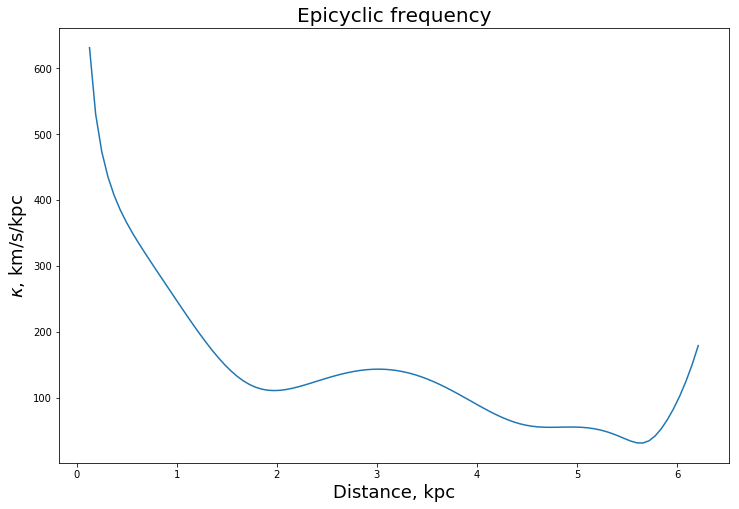

In [137]:
dR = (max(rad) - min(rad)) / 20
kappa = [functions.epic_freq(velocity_approx, r, dR) for r in points]

fig = plt.figure(figsize = [12,8])     
plt.plot(points, kappa) 
plt.title('Epicyclic frequency',fontsize = 20)
plt.ylabel('$\kappa$, km/s/kpc', fontsize = 18)
plt.xlabel('Distance, kpc', fontsize = 18)
plt.show()

In [138]:
sigma_s = np.load('sigma_s.npy')
H_alpha = np.load('H_alpha.npy')
Sigma_H2 = np.load('Sigma_H2.npy')
sigma_HI = np.load('sigma_HI.npy')
Sigma_HI = np.load('Sigma_HI.npy')
Sigma_s = np.load('Sigma_s.npy')

## Оценки радиальной дисперсии

In [139]:
size = [380,140]
data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size)
cposition= SkyCoord('170.06318266 12.99640067', frame='icrs', unit='deg', equinox='J2000.0')
cpixel = skycoord_to_pixel(cposition,data.wcs)
print(cpixel)
                    

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
(array(32.0778305), 

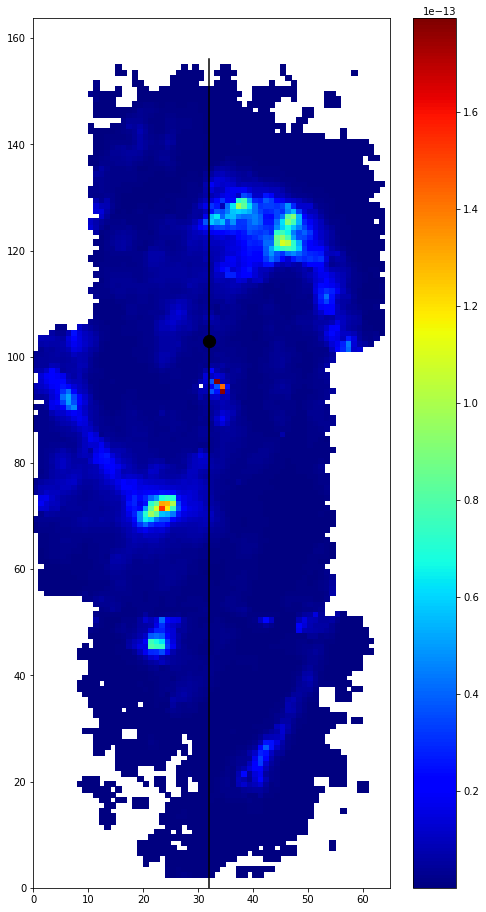

In [140]:
X,Y = np.meshgrid(np.arange(0.,len(H_alpha[0]),1), np.arange(0.,len(H_alpha),1))

plt.figure(figsize=[8,16])
quadmesh = plt.pcolormesh(X, Y, H_alpha, cmap=cm.jet)
plt.colorbar()
plt.scatter(32.0778305,103.00132757,[150.], color='black' )
plt.plot([32.0778305,32.0778305], [0.,156.], color='black')

Попробуем провести большую полуось c PA=178

In [141]:
32.0778305 - 103.00132757 * np.tan(12.*np.pi/180.)

10.184222464273144

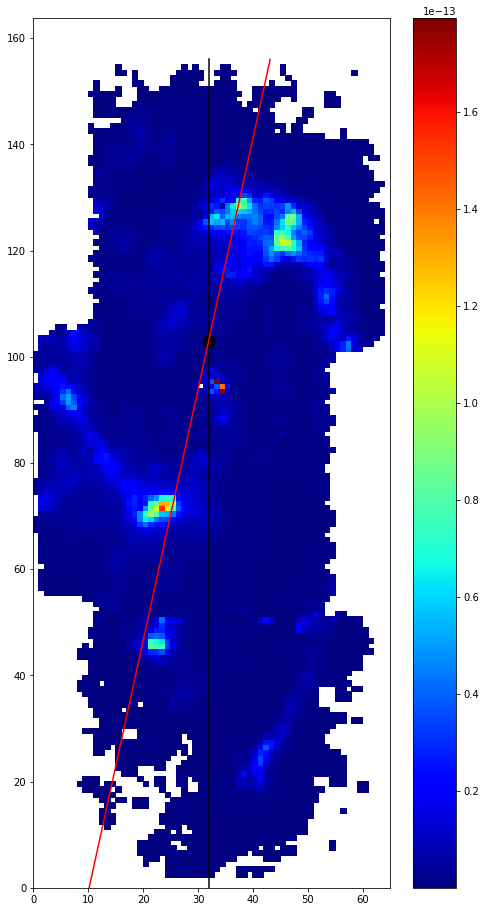

In [142]:
X,Y = np.meshgrid(np.arange(0.,len(H_alpha[0]),1), np.arange(0.,len(H_alpha),1))

plt.figure(figsize=[8,16])
quadmesh = plt.pcolormesh(X, Y, H_alpha, cmap=cm.jet)
plt.colorbar()
plt.scatter(32.0778305 ,103.00132757,[150.], color='black' )
plt.plot([32.0778305 ,32.0778305 ], [0.,156.], color='black')
plt.plot([10.18,10.18 + 155. * np.tan(12.*np.pi/180)], [0., 156], color='red')

### Рассчитаем углы

In [143]:
def angles(V1,U1,V2,U2,V3,U3):
    c = (V3-V1)**2 + (U3-U1)**2
    a = (V2-V1)**2 + (U2-U1)**2
    b = (V3-V2)**2 + (U3-U2)**2
    
    cos = (c-a-b)  / 2 / math.sqrt(a) / math.sqrt(b)
    return math.acos(cos)

In [144]:
phi = np.zeros(sigma_s.shape)

for i in range(len(sigma_s[0])):
    for j in range(len(sigma_s)):
        phi[j][i] = angles(i,j,32.0778305 ,103.00132757,10.18,0.)*180./np.pi

/home/lera/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


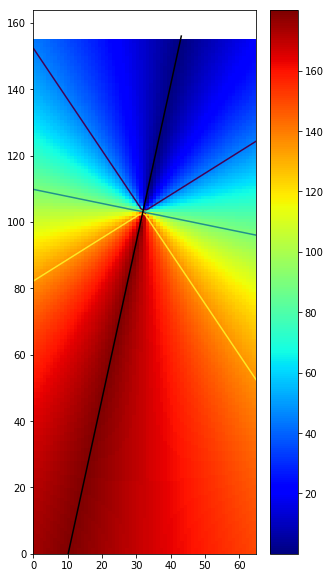

In [145]:
X,Y = np.meshgrid(np.arange(0.,len(sigma_s[0]),1), np.arange(0.,len(sigma_s),1))

plt.figure(figsize=[5, 10])
quadmesh = plt.pcolormesh(X, Y, phi, cmap=cm.jet)
# quadmesh.set_clim(vmin=6.0, vmax=80.)
plt.colorbar()
quadmesh.cmap.set_under('white')
quadmesh.cmap.set_over('white')

CS = plt.contour(X, Y, phi, levels=[45., 90., 135.], aspect='auto')

plt.plot([10.18,10.18 + 155. * np.tan(12.*np.pi/180)], [0., 156], color='black')

## $\sigma_{R}^{max}$ & $\sigma_{R}^{min}$ 

$$ \sigma^2_{los,\phi}=(\sigma^2_{R}\cdot\sin^2{\phi}+\sigma^2_{\phi}\cdot\cos^2{\phi})\cdot\sin^2{i}+\sigma^2_{z}\cdot\cos^2{i}$$

С учётом того $0.09\leq\dfrac{\sigma^2_{z}}{\sigma^2_{R}}\leq0.49$ и $0.25\leq\dfrac{\sigma^2_{\varphi}}{\sigma^2_{R}}\leq1$

$$\sigma_{R}^{max}=\frac{\sigma_{los,\phi}}{\sqrt{sin^2{i}\cdot\sin^2{\phi} + 0.25\cdot\sin^2{i}\cdot\cos^2{\phi} + 0.09\cdot\cos^2{i}}}$$

$$\sigma_{R}^{min}=\frac{\sigma_{los,\phi}}{\sqrt{sin^2{i} + 0.49\cdot\cos^2{i}}}$$

In [146]:
sig_r_max = lambda sig, phi_: sig/np.sqrt(sini**2 * np.sin(phi_*np.pi/180.)**2 + 0.25*sini**2*np.cos(phi_*np.pi/180.)**2 + 0.09*cosi**2) 
sig_r_min = lambda sig, phi_: sig/np.sqrt(sini**2 + 0.49*cosi**2)

In [147]:
sig_R_max = np.zeros(sigma_s.shape)

for i in range(len(sigma_s)):
    for j in range(len(sigma_s[0])):
        sig_R_max[i][j] = sig_r_max(sigma_s[i][j], phi[i][j])
        
sig_R_min = np.zeros(sigma_s.shape)

for i in range(len(sigma_s)):
    for j in range(len(sigma_s[0])):
        sig_R_min[i][j] = sig_r_min(sigma_s[i][j], phi[i][j])

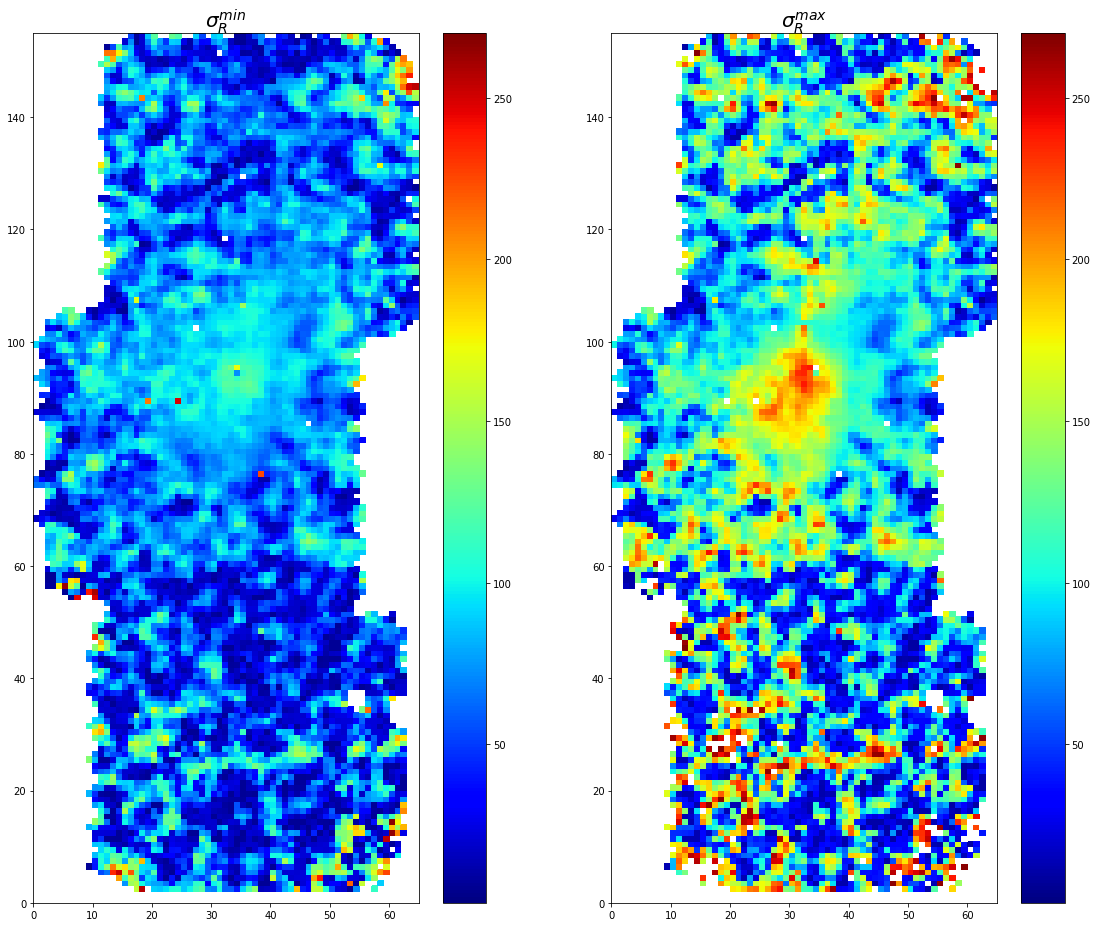

In [148]:
plt.figure(figsize=[19, 16])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, sig_R_min, cmap=cm.jet)
quadmesh.set_clim(vmin=1.0, vmax=270.)
plt.colorbar()
plt.title(r'$\sigma_R^{min}$', fontsize=20)

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y, sig_R_max, cmap=cm.jet)
quadmesh.set_clim(vmin=1.0, vmax=270.)
plt.colorbar()
plt.title(r'$\sigma_R^{max}$',fontsize=20)
plt.show()

In [149]:
sig_R_max = np.save('sig_R_max.npy', sig_R_max)
sig_R_min = np.save('sig_R_min.npy', sig_R_min)

## Расстояния от центра

In [150]:
size = [380,140]
data, second_data = cut_fits(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC3627.phot.1_nonan.fits', size = size)
cposition= SkyCoord('170.06318266 12.99640067', frame='icrs', unit='deg', equinox='J2000.0')

shape = data.shape
data_wcs = data.wcs
X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), data_wcs).reshape((shape[0], shape[1]))

dist = np.zeros((156,66))
for i in range(len(dist)):
    for j in range(len(dist[0])):
        scoord = sgrid[i][j]
        dist[i][j] = cposition.separation(scoord).arcsec

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [151]:
#Переведём в kpc
dist_kpc = dist * np.pi / (180 *3600) * Distance * 10**3

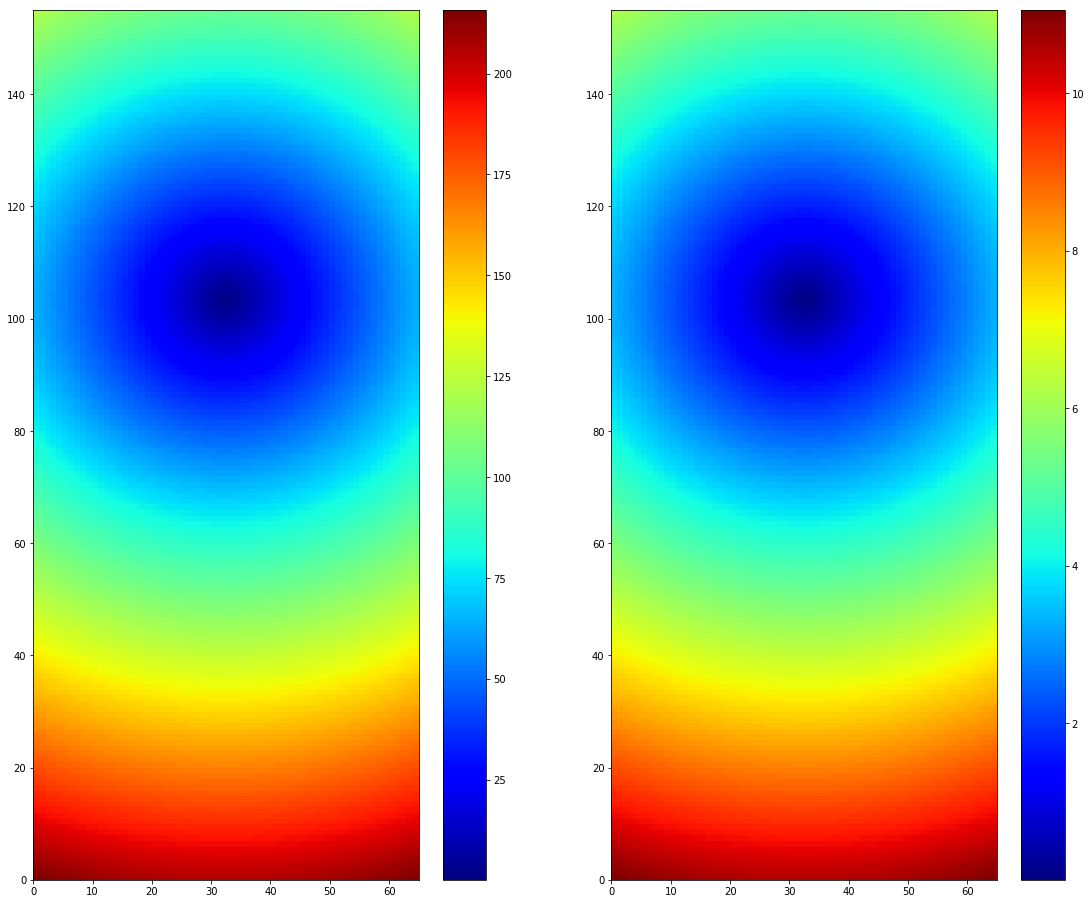

In [152]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[19, 16])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, dist, cmap='jet')
plt.colorbar()

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y, dist_kpc, cmap='jet')
plt.colorbar()


In [153]:
dist_kpc = np.save('dist_kpc.npy',dist_kpc)

### Сравним скорости

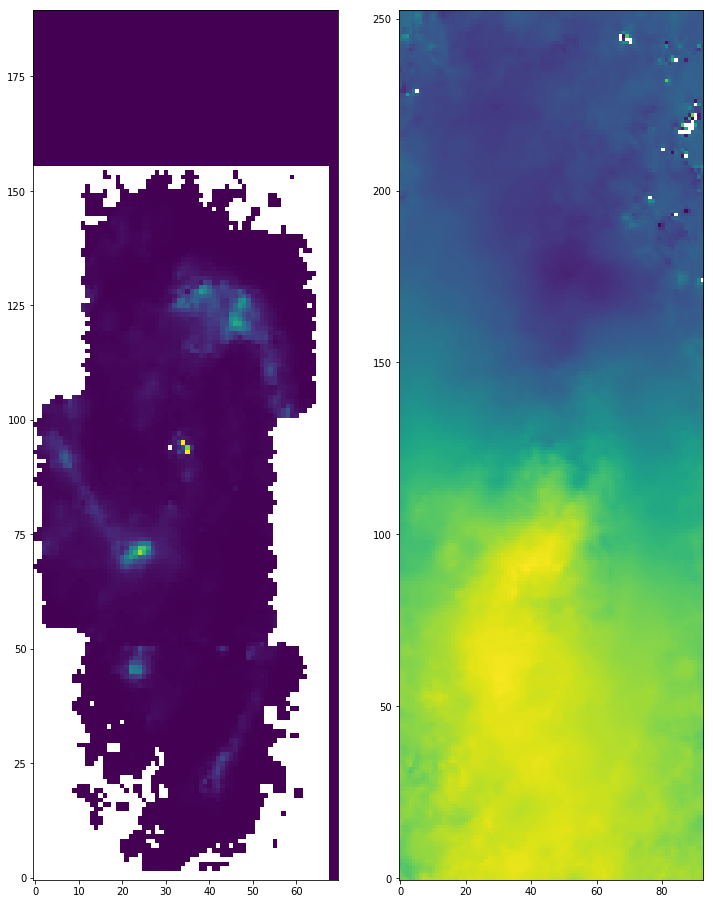

(190, 70)
(253, 93)


In [154]:
size = [380,140] 
first_data, second_data = cut_fits(first_fits='./data/NGC3627_map_ha_corr.fits', second_fits='./data/NGC_3627_NA_MOM1_THINGS.FITS', size=size) 

fig, [ax, ax2] = plt.subplots(figsize=[12, 16], ncols=2)
ax.imshow(first_data.data, origin='lower', aspect="auto")
ax2.imshow(second_data.data, origin='lower', aspect="auto")
plt.show()

print(first_data.shape)
print(second_data.shape)  

In [155]:
size = [380,140]
grid_pix, velocity = create_new_grid(first_fits = './data/NGC3627_map_ha_corr.fits', second_fits = './data/NGC_3627_NA_MOM1_THINGS.FITS', size = size) 

In [156]:
velocity = np.array(velocity).reshape(190,70)

In [157]:
#fig = plt.figure(figsize=[18,17])
#ax1 = fig.add_subplot(121)
#ax1.imshow(H_alpha.data, origin='lower', aspect="auto")


ax2 = fig.add_subplot(122)
velocity_cut= velocity[0:-34,0:-4]
ax2.imshow(velocity_cut.data, origin='lower', aspect="auto")

#print(H_alpha.shape)
print(velocity_cut.shape)

(156, 66)


In [158]:
veloc_norm = lambda l: (l/1000. - 659.1)/sini
vel= veloc_norm(velocity_cut)

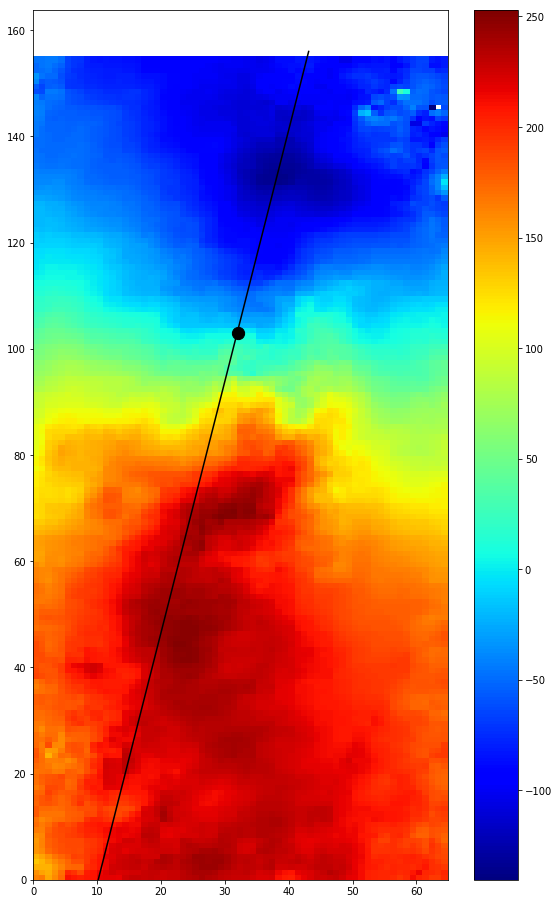

In [159]:
X,Y = np.meshgrid(np.arange(0.,len(vel[0]),1), np.arange(0.,len(vel),1))
plt.figure(figsize=[9.3,16])
quadmesh = plt.pcolormesh(X, Y, vel, cmap='jet')
plt.colorbar()
plt.scatter(32.0778305 ,103.00132757,[150.], color='black' )
plt.plot([10.18,10.18 + 155. * np.tan(12.*np.pi/180)], [0., 156], color='black')

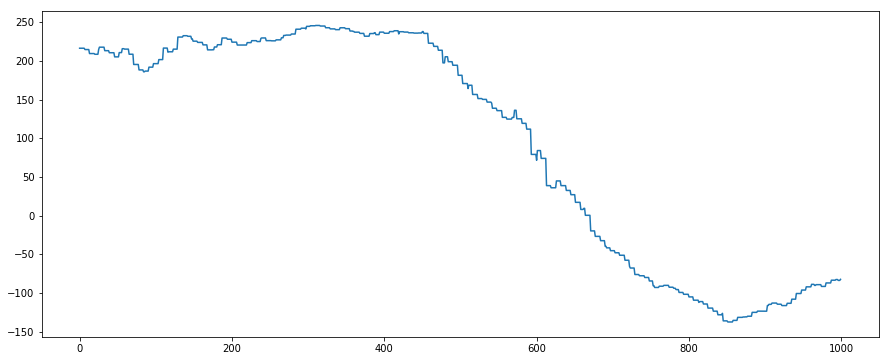

In [160]:
import scipy.ndimage

x0, y0 = 10.18, 0. # These are in _pixel_ coordinates!!
x1, y1 = 10.18 + 155. * np.tan(12.*np.pi/180.),155.
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = scipy.ndimage.map_coordinates(vel, np.vstack((y,x)))
zi_cub = vel[y.astype(np.int), x.astype(np.int)]

fig = plt.figure(figsize = [15, 6])
line = plot(zi_cub)



Хотим пиксели перевести в arcsec. Получается, что на 200 arcsec приходится 103 пикселя (если центр галактики определяется правильно). Тогда на один пиксель приходится порядка 1.9 arcsec. 

In [161]:
#Определим длину нашего среза
r_vel = np.sqrt(155.**2 + (155. * np.tan(12.*np.pi/180))**2)
#Переведём в arcsec
r_vel = r_vel * 1.9
#Найдём центр галактики на срезе
c_r_vel = 103.00132757 / math.cos(12.*np.pi/180.)
c_r_vel = c_r_vel * 1.9

In [162]:
#r_HI, vel_HI = zip(*sorted(zip(np.abs(np.linspace(0., r_vel, 1000)-c_r_vel), np.abs(zi_cub)))) 
vel_HI = sort(np.abs(zi_cub))
r_HI = sort(np.abs(np.linspace(0., r_vel, 1000)-c_r_vel))
r_HI = r_HI * np.pi / (180 *3600) * Distance * 10**3 # переведём в kpc

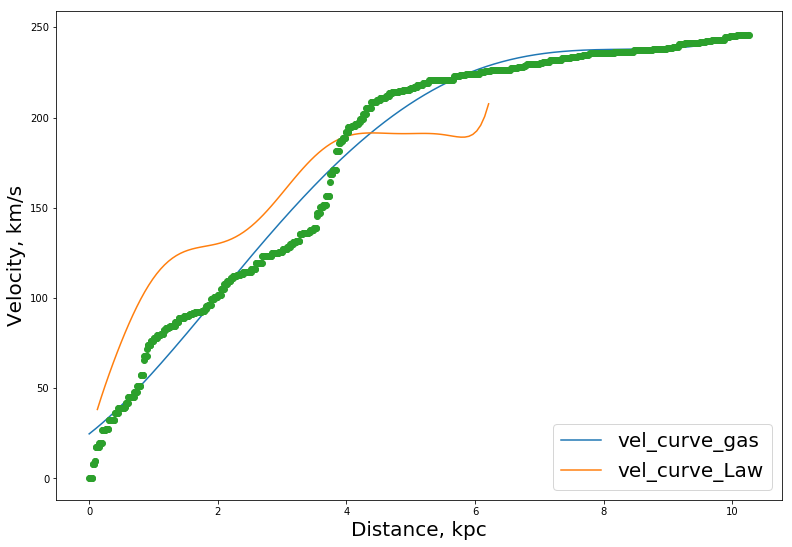

In [163]:
r_Law = np.load('r_Law.npy')
vel_Law = np.load('vel_Law.npy')
points = np.linspace(min(r_HI), max(r_HI), 1000)
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))
fig, ax = plt.subplots(figsize=[13,9])
line1 = ax.plot(points, velocity_approx(points), label='vel_curve_gas')
line2 = ax.plot(r_Law, vel_Law, label='vel_curve_Law')
line3 = ax.plot(r_HI, vel_HI, 'o')
plt.ylabel('Velocity, km/s', fontsize = 20)
plt.xlabel('Distance, kpc', fontsize = 20)
plt.legend(loc='lower right',fontsize=20)
plt.show()

In [164]:
r_HI = np.save('r_HI.npy', r_HI)
vel_HI = np.save('vel_HI.npy', vel_HI)

### Посчитаем ещё раз эпициклическую частоту

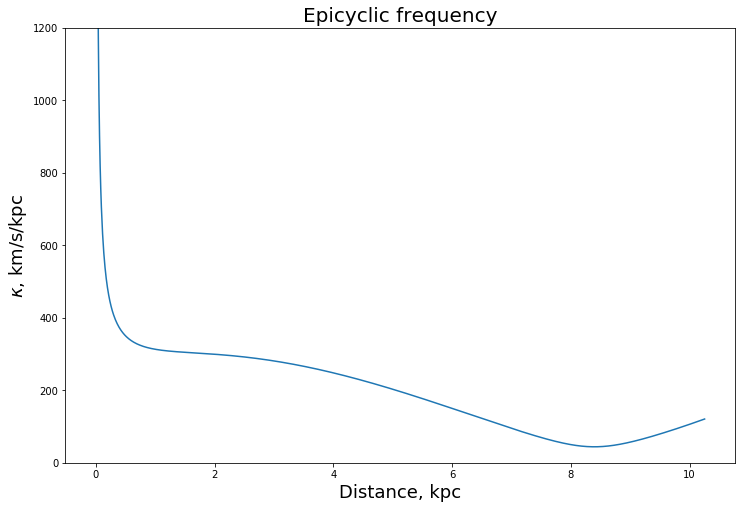

In [165]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
kappa = [functions.epic_freq(velocity_approx, r, dR) for r in points]

fig = plt.figure(figsize = [12,8])     
plt.plot(points, kappa) 
plt.title('Epicyclic frequency',fontsize = 20)
plt.ylabel('$\kappa$, km/s/kpc', fontsize = 18)
plt.xlabel('Distance, kpc', fontsize = 18)
plt.ylim(0, 1200.)
plt.show()

In [166]:
kappa = np.save('kappa.npy', kappa)

### SFR

 $$\frac{SFR}{M_{\odot}yr^{-1}} = 5.37\times 10^{-42} \frac{L_{H\alpha}}{erg \times s^{-1}}$$

$$L(H_{\alpha}) = 4\pi (3.086\times 10^{24} d_L)^2 f(H_{\alpha})$$, where f(Hα) is the integrated flux in ergs s-1 cm-2 and dL is the luminosity distance in Mpc

## Выведем все данные и посмотрим на их размерности.

In [167]:
sigma_s = np.load('sigma_s.npy')
H_alpha = np.load('H_alpha.npy')
Sigma_H2 = np.load('Sigma_H2.npy')
sigma_HI = np.load('sigma_HI.npy')
Sigma_HI = np.load('Sigma_HI.npy')
Sigma_s = np.load('Sigma_s.npy')
sig_R_max = np.load('sig_R_max.npy')
sig_R_min = np.load('sig_R_min.npy')

Text(0.5, 1.0, '$H_{a}$')

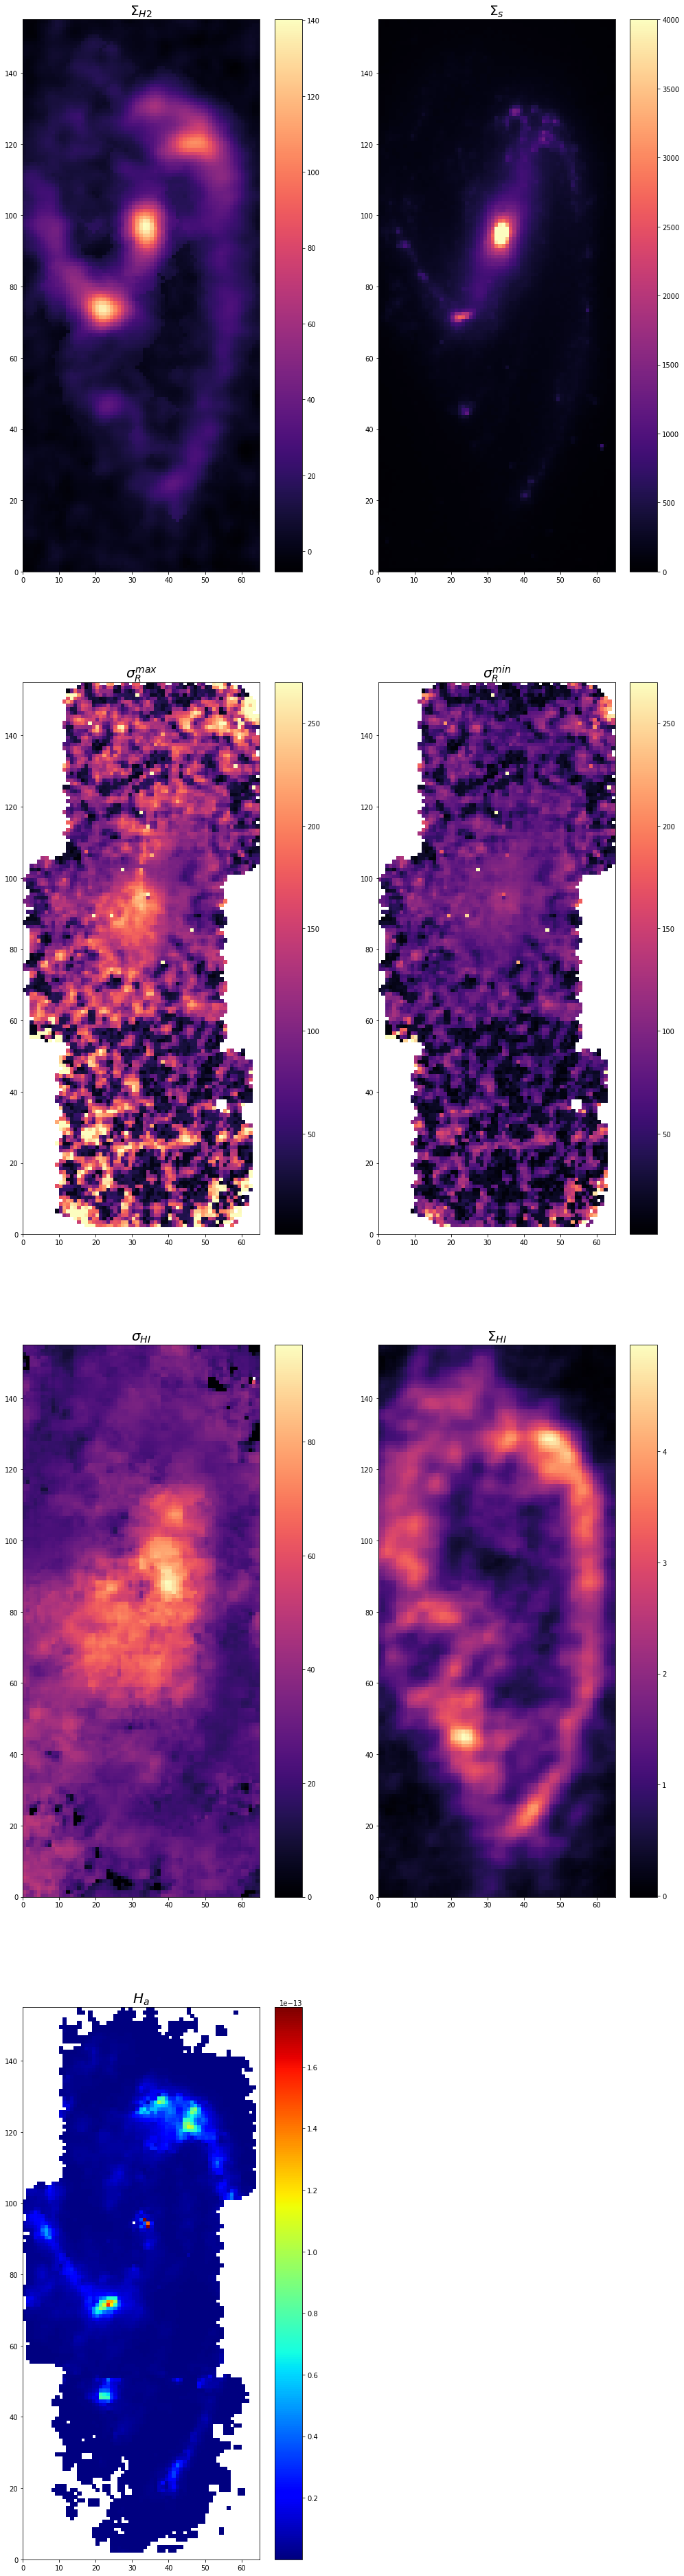

In [168]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 68])
plt.subplot(4,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_H2, cmap='magma')
plt.colorbar()
plt.title(r'$\Sigma_{H2}$', fontsize=20)

plt.subplot(4,2,2)
quadmesh = plt.pcolormesh(X, Y, Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax=4000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\Sigma_{s}$', fontsize=20)

plt.subplot(4,2,3)
quadmesh = plt.pcolormesh(X, Y, sig_R_max, cmap='magma')
quadmesh.set_clim(vmin=1.0, vmax=270.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\sigma_R^{max}$', fontsize=20)

plt.subplot(4,2,4)
quadmesh = plt.pcolormesh(X, Y, sig_R_min, cmap='magma')
quadmesh.set_clim(vmin=1.0, vmax=270.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\sigma_R^{min}$', fontsize=20)

plt.subplot(4,2,5)
quadmesh = plt.pcolormesh(X, Y, sigma_HI/1000., cmap='magma')
plt.colorbar()
plt.title(r'$\sigma_{HI}$', fontsize=20)

plt.subplot(4,2,6)
quadmesh = plt.pcolormesh(X, Y, Sigma_HI, cmap='magma')
plt.colorbar()
plt.title(r'$\Sigma_{HI}$', fontsize=20)

plt.subplot(4,2,7)
quadmesh = plt.pcolormesh(X, Y, H_alpha, cmap='jet')
plt.colorbar()
plt.title(r'$H_{a}$', fontsize=20)